In [7]:
import sys
sys.path.append('../../..')
from planthealth import core
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from time import time
import cv2


Orignal images had dimensions:  (660, 860)

Time to open= 0.03697395324707031 s
Time to register= 0.03496122360229492 s
Time to split= 0.0030205249786376953 s
Time to map= 0.009994268417358398 s
Time to write(cv2.imwrite)= 0.021986722946166992 s
Time to write(Image.save)= 0.023984909057617188 s
Total time to process= 0.10893487930297852 s


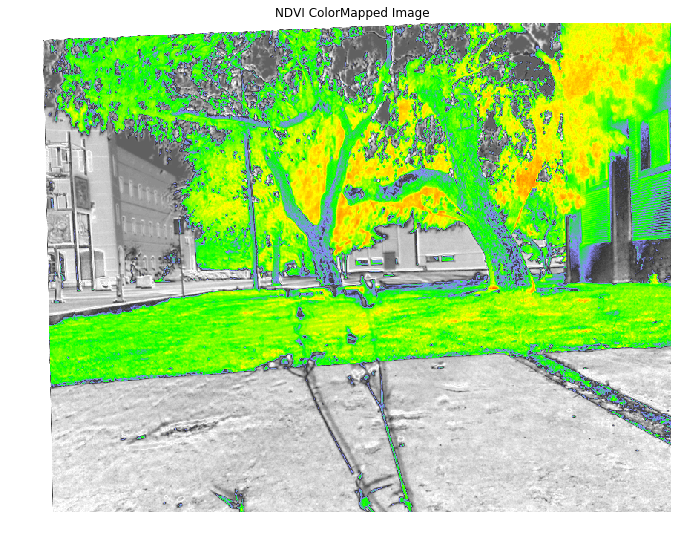

In [11]:
# Read reference image
t = time()
imReference = cv2.imread('../Images/RGB.png', cv2.IMREAD_COLOR)
#[b, g, r] = cv2.split(imReference)

# Read image to be aligned
im = cv2.imread('../Images/NGB.png', cv2.IMREAD_COLOR)
#[b2, g2, r2] = cv2.split(im)
t_open = time() - t

# Registered image will be restored in imReg. 
# The estimated homography will be stored in h.
starttime = time()
imReg = core.alignImages(im, imReference)
t_reg = time()-starttime # Time tracking of registration
regtime = time()

#color map with Jessi's registered images
[b, g, Rimg] = cv2.split(imReference)
[b, g, NIRimg] = cv2.split(imReg)
t_split = time()-regtime
splittime = time()
NDVIimg = core.ndvi_map(Rimg, NIRimg)
t_map = time() - splittime # Time tracking of color mapping

# Write aligned image to disk. 
t = time()
cv2.imwrite("../Images/aligned.jpg", imReg)
t_cv2 = time() - t
#can't save ndvi_map() result with cv2.imwrite because B and R are swapped from CMAP
t = time()
Image.fromarray(NDVIimg).save("../Images/NDVI_feature.jpg")
t_Imagesave = time() - t

# Display Results
print('\nOrignal images had dimensions: ', Rimg.shape)
print("\nTime to open= "+ str(t_open) +" s")
print("Time to register= "+ str(t_reg) +" s")
print("Time to split= "+ str(t_split) +" s")
print("Time to map= "+ str(t_map) +" s")
print("Time to write(cv2.imwrite)= "+ str(t_cv2) +" s")
print("Time to write(Image.save)= "+ str(t_Imagesave) +" s")

print("Total time to process=", t_open+t_map+t_split+t_reg+t_Imagesave, "s")

# Plot NDVI ColorMapped Image
plt.figure(figsize=(12,9))
plt.imshow(NDVIimg)
plt.axis('off')
plt.title('NDVI ColorMapped Image')
plt.show()


In [ ]:
# Show images in new windows
image1 = Image.open('Documents/Github:Python/PlantHealth/planthealth/tests/Images/RGB.png')
image1.show()
image2 = Image.open('Documents/Github:Python/PlantHealth/planthealth/tests/Images/NGB.png')
image2.show()
aligned = Image.open('aligned.jpg')
aligned.show()
matches= Image.open('matches.jpg')
matches.show()

In [12]:
def alignImages(im1, im2):

    # Convert images to grayscale
    im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(MAX_FEATURES)
    keypoints1, descriptors1 = orb.detectAndCompute(im1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2, None)

    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)

    # Sort matches by score.
    matches.sort(key=lambda x: x.distance, reverse=False)

    # Remove not so good matches.
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]

    # Draw top matches.
    imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
    cv2.imwrite("../Images/matches.jpg", imMatches)
    
    # Extract location of good matches.
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt


    #print("Points 1", points1) 
    #print("Points 2", points2) 

    # Find homography.
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Use homography.
    height, width, channels = im2.shape
    im1Reg = cv2.warpPerspective(im1, h, (width, height))

    #shiftXY, error, diffphase = register_translation(Rimg, NIRoff) 

    # Shifts first element by second element amount
    #NIRimg = shift(NIRoff, np.array(shiftXY))
    #NDVIimg = ndvi_map(Rimg, NIRimg)

    # Plot NDVI ColorMapped Image
    #plt.imshow(NDVIimg)
    #plt.axis('off')
    #plt.title('NDVI ColorMapped Image')

    return im1Reg